In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from __future__ import division

In [3]:
#plt.savefig('MagTime')

In [46]:
k = 1
T = 2.5 #In Units of e/K
t = 1000 #Number of MC timesteps
Temps = np.arange(.5,5,.05)
Lengths = np.arange(2,26,2)

In [47]:
FieldsA = -np.arange(-1,1,.1)
FieldsB = np.arange(-1,1.1,.1)
Fields = np.append(FieldsA,FieldsB)

# Generating the Lattice

In [6]:
def latticeGen(rows,cols):
    """Return a 2d lattice of shape (rows,cols) comprised of randomly generated spins (1 or -1)."""
    array = np.zeros((rows,cols),dtype=np.float)
    #Loop over all entries in array and randomly assign them a spin individually.
    for i in np.arange(rows):
        for j in np.arange(cols):
            array[i,j] = np.random.choice([1,-1])
    return array

In [7]:
RngLattice = latticeGen(10,10)
TestLattice = np.copy(RngLattice)

# Calculating the Lattice Energy

In [8]:
def pairEnergy(s1,s2):
    "Returns the energy of a single neighbor pair"
    return -s1*s2

In [9]:
def pointEnergy(row,col,lattice):
    """Returns the energy of a single point on the lattice designated by its index (row,col)
    by summing pairEnergy over all of [row,col]'s neighbors"""
    WorkingLattice = np.copy(lattice) #This protects input lattice.
    if row == (WorkingLattice.shape[0] - 1) or col == (WorkingLattice.shape[1] - 1):
        #If we're at an end edge in the rows or columns, roll the array up one. 
        WorkingLattice = np.roll(WorkingLattice,-1,0)
        row = row - 1
        
        WorkingLattice = np.roll(WorkingLattice,-1,1)
        col = col - 1
            
    denergy =   (pairEnergy(WorkingLattice[row,col],WorkingLattice[row+1,col]) + 
                pairEnergy(WorkingLattice[row,col],WorkingLattice[row-1,col]) + 
                pairEnergy(WorkingLattice[row,col],WorkingLattice[row,col+1]) + 
                pairEnergy(WorkingLattice[row,col],WorkingLattice[row,col-1]))
    
    return denergy

In [10]:
def energyArray(lattice):
    """Loop over all entries in lattice, calculate the energy at each point, then place that energy into an
    array of the same shape as the input array, then return the new array containing the energy at each point"""
    rows = lattice.shape[0]
    cols = lattice.shape[1]
    array = np.zeros((rows,cols),dtype=np.float)

    for i in np.arange(rows):
        for j in np.arange(cols):
            array[i,j] = pointEnergy(i,j,lattice)
    return array

#Advancing the Lattice

In [11]:
def boltz(Ef,T):
    "Boltzmann Factor"
    #Where Ef = Eflip is Epostflip - Epreflip
    return np.exp(-Ef/T)

In [12]:
def Flip(row,col,lattice,T):
    """A function that when handed a lattice point will decide whether or not to flip the spin of that point. """
    
    PreFlipLattice = np.copy(lattice)
    PostFlipLattice = np.copy(lattice)
    
    Spin = PreFlipLattice[row,col]
    
    #Flipping the spin at [row,col]
    np.put(PostFlipLattice[row,:],[col],-Spin)
    
    Ef = pointEnergy(row,col,PostFlipLattice) - pointEnergy(row,col,PreFlipLattice)
    
    if Ef <= 0:
        return True
    elif np.random.random_sample() < boltz(Ef,T): #Return random floats in the half-open interval [0.0, 1.0).
        return True
    else:
        return False

In [13]:
def LatticeAdvance(lattice,T):
    """Performs a single monte carlo timestep. Loops over every point in the lattice and Flips the spin
        of that point if Flip returns True. Then returns the final lattice."""
    for i in np.arange(lattice.shape[0]):
            for j in np.arange(lattice.shape[1]):
                Spin = lattice[i,j]
                if Flip(i,j,lattice,T):
                    np.put(lattice[i,:],[j],-Spin)
    return lattice

# 1. Average Magnetization and Energy

In [14]:
def AverageM(lattice):
    "Returns the Average Magnetization (Spin) of the input lattice."
    M = np.sum(lattice)/np.size(lattice)
    return M

In [15]:
def AverageE(lattice):
    "Returns <E> of the Input lattice."
    EAvg = np.sum(energyArray(lattice))/np.size(lattice)
    return EAvg

In [16]:
def AverageE2(lattice):
    "Returns <E^2> for the Input lattice."
    EAvg = np.sum([entry**2 for entry in energyArray(lattice)])/np.size(lattice)
    return EAvg

# Monte Carlo Simulation

In [17]:
def Sim(lattice,T,t):
    """Advances the input lattice for t number of monte carlo time units and returns four arrays
    
    Returns:
    FinalLattice- The final lattice configuration after t timesteps.
    Energies- <E> for each past configuration
    Energies2- <E^2> for each past configuration
    Magnetizations- <M> for each past config"""
    
    CurrentLattice = np.copy(lattice)
    
    Energies =       np.array([AverageE(CurrentLattice)]) #<E>
    Energies2 =      np.array([AverageE2(CurrentLattice)]) #<E^2>
    Magnetizations = np.array([AverageM(CurrentLattice)])
    
    for i in np.arange(t):
        CurrentLattice = LatticeAdvance(CurrentLattice,T)
        
        Energies =       np.append(Energies, AverageE(CurrentLattice))
        Energies2 =      np.append(Energies2, AverageE2(CurrentLattice))
        Magnetizations = np.append(Magnetizations,AverageM(CurrentLattice))
        
    FinalLattice = CurrentLattice
    
    #Slicing off the first entries. They're from the randomly generated lattice.
    Energies = Energies[1:]
    Energies2 = Energies2[1:]
    Magnetizations = Magnetizations[1:]
    
    return FinalLattice, Energies, Energies2, Magnetizations

# 2. Lattice Energy/Magnetization vs. "Time"

In [18]:
def myplot(x,y):
    #Removing Top/Right Spine/Ticks
    f, ax = plt.subplots(1, 1,figsize=(14,6))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    plt.plot(x,y);
steps = np.arange(t)

##### T = 1.1

In [19]:
T = 1.1 #In Units of e/K
SimLattice, Energies, Energies2, Magnetizations = Sim(TestLattice,T,t)

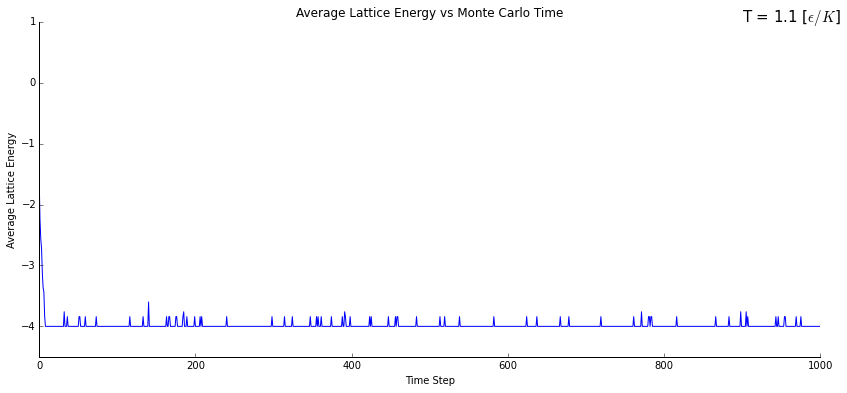

In [20]:
myplot(steps,Energies)
plt.xlabel("Time Step");
plt.ylabel("Average Lattice Energy");
plt.title("Average Lattice Energy vs Monte Carlo Time");
plt.ylim(-4.5,1);
plt.text(np.max(steps)*.9,1,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

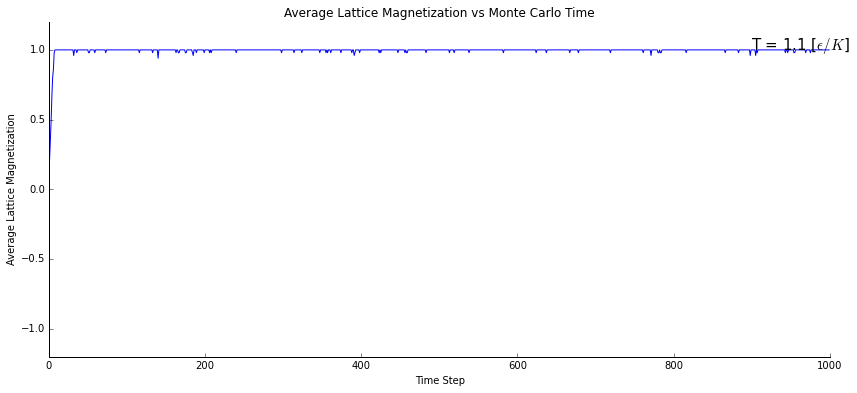

In [21]:
myplot(steps,Magnetizations)
plt.xlabel("Time Step");
plt.ylabel("Average Lattice Magnetization");
plt.title("Average Lattice Magnetization vs Monte Carlo Time");
plt.ylim(-1.2,1.2);
plt.text(np.max(steps)*.9,1,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

##### T = 1.8

In [22]:
T = 1.8 #In Units of e/K
SimLattice, Energies, Energies2, Magnetizations = Sim(TestLattice,T,t)

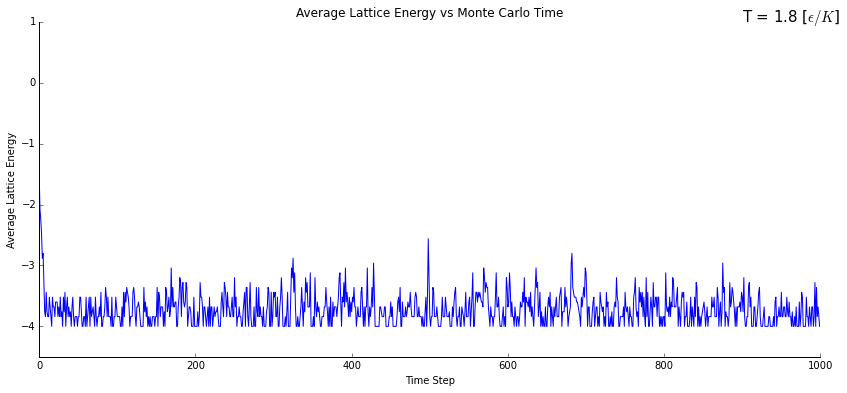

In [23]:
myplot(steps,Energies)
plt.xlabel("Time Step");
plt.ylabel("Average Lattice Energy");
plt.title("Average Lattice Energy vs Monte Carlo Time");
plt.ylim(-4.5,1);
plt.text(np.max(steps)*.9,1,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

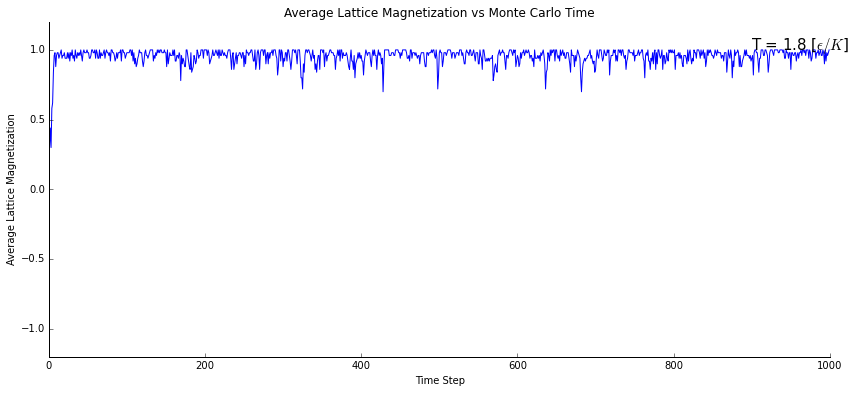

In [24]:
myplot(steps,Magnetizations)
plt.xlabel("Time Step");
plt.ylabel("Average Lattice Magnetization");
plt.title("Average Lattice Magnetization vs Monte Carlo Time");
plt.ylim(-1.2,1.2);
plt.text(np.max(steps)*.9,1,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

##### T = 2.5

In [25]:
T = 2.5 #In Units of e/K
SimLattice, Energies, Energies2, Magnetizations = Sim(TestLattice,T,t)

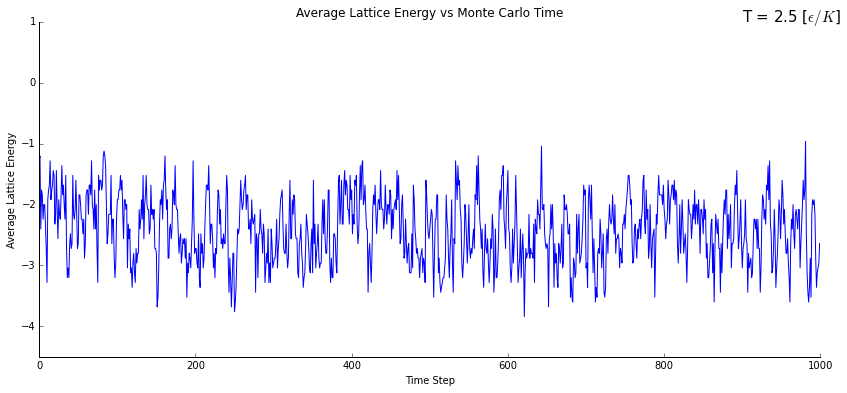

In [26]:
myplot(steps,Energies)
plt.xlabel("Time Step");
plt.ylabel("Average Lattice Energy");
plt.title("Average Lattice Energy vs Monte Carlo Time");
plt.ylim(-4.5,1);
plt.text(np.max(steps)*.9,1,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

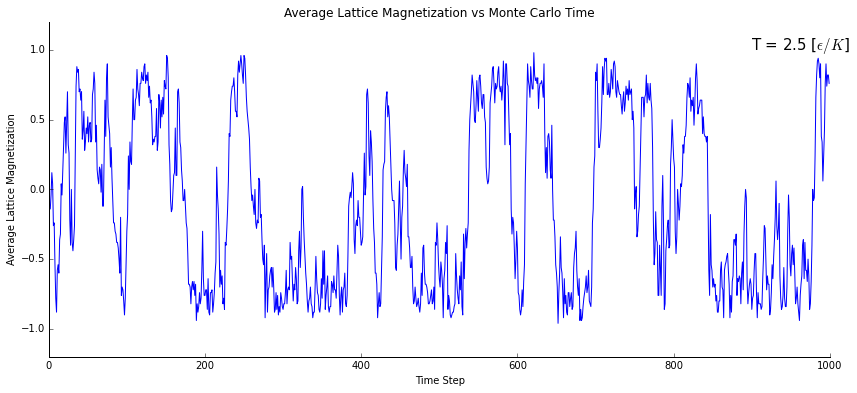

In [27]:
myplot(steps,Magnetizations)
plt.xlabel("Time Step");
plt.ylabel("Average Lattice Magnetization");
plt.title("Average Lattice Magnetization vs Monte Carlo Time");
plt.ylim(-1.2,1.2);
plt.text(np.max(steps)*.9,1,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

In your script, compute the energy and magnetization per spin for 1000 time steps (cycling through the lattice to find a new microstate) for T = 1.1 and plot them vs. the Monte Carlo time steps. Do these plots make sense?

The plots seem to make sense. At low temperature there are few fluctuations and the lattice remains near the lowest energy. As the temperature is increased the fluctuations increase.

# 3. Energy vs. Lattice Size

##### T = 1.1

In [44]:
T = 1.1 #In Units of e/K
AvgE = np.array([np.mean(Sim(latticeGen(i,i),T,t)[1]) for i in Lengths])

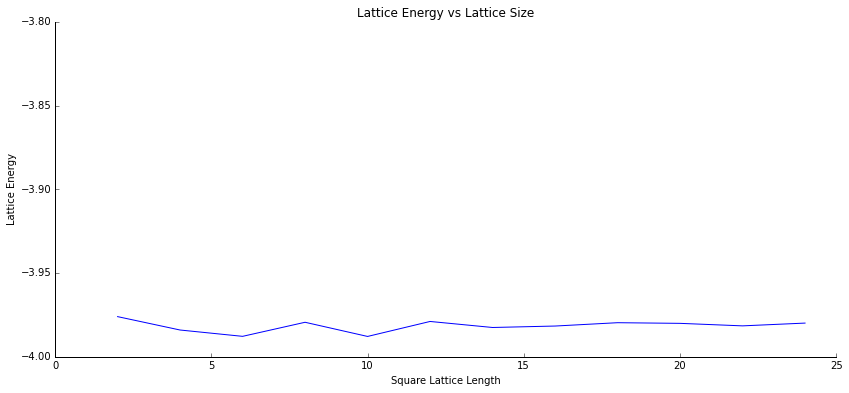

In [45]:
myplot(Lengths,AvgE)
plt.xlabel("Square Lattice Length");
plt.ylabel("Lattice Energy");
plt.title("Lattice Energy vs Lattice Size");
plt.ylim(-4,-3.8);
#plt.text(np.max(Lengths)*.8,np.max(AvgE),"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

##### T = 1.8

In [30]:
T = 1.8 #In Units of e/K
AvgE = np.array([np.mean(Sim(latticeGen(i,i),T,t)[1]) for i in Lengths])

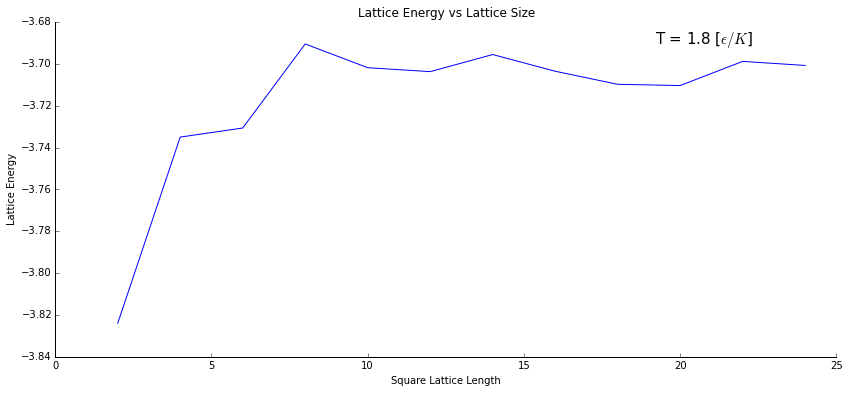

In [31]:
myplot(Lengths,AvgE)
plt.xlabel("Square Lattice Length");
plt.ylabel("Lattice Energy");
plt.title("Lattice Energy vs Lattice Size");
plt.text(np.max(Lengths)*.8,np.max(AvgE),"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

##### T = 2.5

In [32]:
T = 2.5 #In Units of e/K
AvgE = np.array([np.mean(Sim(latticeGen(i,i),T,t)[1]) for i in Lengths])

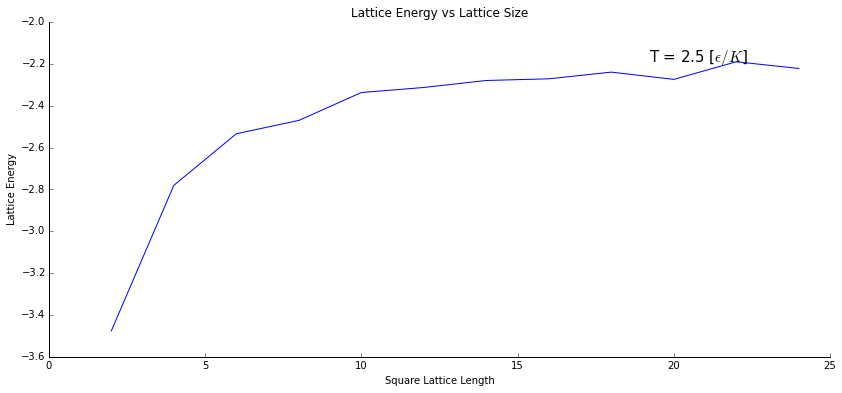

In [33]:
myplot(Lengths,AvgE)
plt.xlabel("Square Lattice Length");
plt.ylabel("Lattice Energy");
plt.title("Lattice Energy vs Lattice Size");
plt.text(np.max(Lengths)*.8,np.max(AvgE)*1.1,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

Generate a plot showing how the lattice size affects the calculated energy and explain what is happening.

We should expect the lattice energy to increase as the lattice size increases. A small lattice is essentially a single domain and due to the periodic boundary conditions a dipole  may interact with the same neighbor twice. As the lattice size increases, the percentage of dipoles that are on the edge decreases and our system properties will be dominated by the bulk and we have a decent estimate of a true thermodynamic system.

At T = 1.1 [$\epsilon$/K] lattices of all sizes in this range give similar energies. This must be a very cold temperature for the lattice when compared to T = 1.8[$\epsilon$/K]

# 4. Energy/Magnetization vs Temperature

In [34]:
def SpecHeat(E,E2,T):
    "Computes the specific heat at a temperature when handed <E> and <E^2>"
    variance = E2 - E**2
    c = variance/(T**2)
    
    return c

In [35]:
def TempIncrease(lattice,Temps,t):
    """Advances the input lattice (t number of MC time units) for each temperature in Temps 
       without resetting the lattice at each new temperature.
       
    Returns:
    Energies_ - <E> of the equilibrium lattice for each temperature.
    Magnetizations_ - <M> of the equilibrium lattice for each temperature
    SpecificHeat - Calculated from the variance of <E> and <E^2> from the "equilibrium state" at the end of each temperature.
    """
    Lattices = np.array([lattice])
    CurrentLattice = np.copy(lattice)
    
    #Initializing arrays, will append data from each temperature to these arrays.
    Energies_ = np.array([AverageE(CurrentLattice)]) #<E>
    Energies2_ = np.array([AverageE2(CurrentLattice)]) #<E^2>
    Magnetizations_ = np.array([AverageM(CurrentLattice)])
    SpecificHeat = np.array([SpecHeat(Energies_[0],Energies2_[0],T)])
    
    for i in np.arange(len(Temps)):
        CurrentLattice, Energies, Energies2, Magnetizations = Sim(CurrentLattice,Temps[i],t)
        
        Lattices = np.append(Lattices,CurrentLattice)
        Energies_ = np.append(Energies_,np.mean(Energies))
        #Energies2_ = np.append(Energies2_,Energies2[-1])
        
        Magnetizations_ = np.append(Magnetizations_,np.mean(Magnetizations))
        SpecificHeat = np.append(SpecificHeat, SpecHeat(np.mean(Energies),np.mean(Energies2),Temps[i]))
        
    #Slicing off the first entries, they are from first lattice (randomly generated) and don't match to any temperature.   
    Energies_ = Energies_[1:]
    Magnetizations_ = Magnetizations_[1:]
    SpecificHeat = SpecificHeat[1:]
    
    return Energies_, SpecificHeat, Magnetizations_

In [36]:
Energies_, SpecificHeat, Magnetizations_ = TempIncrease(TestLattice,Temps,t)

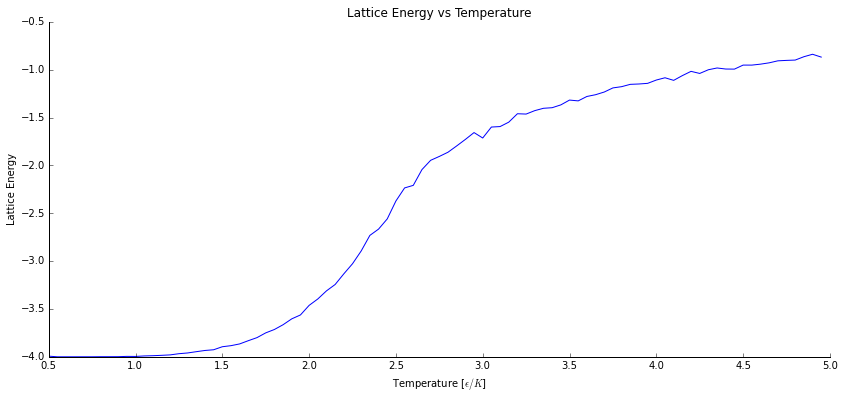

In [37]:
myplot(Temps,Energies_)
plt.xlabel("Temperature [$\epsilon /K$]");
plt.ylabel("Lattice Energy");
plt.title("Lattice Energy vs Temperature");

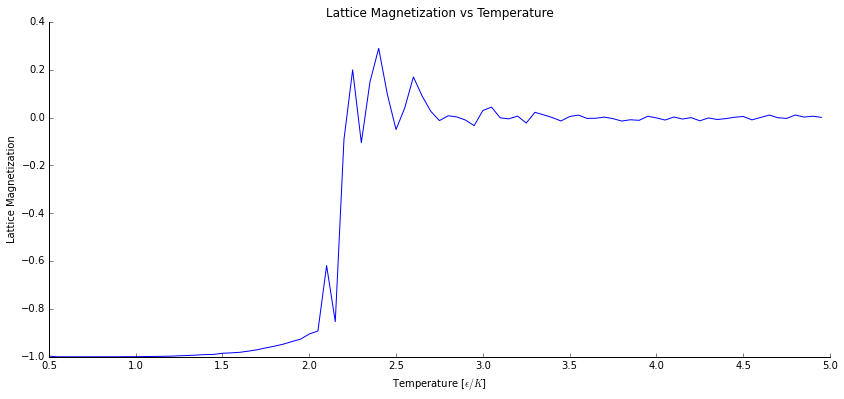

In [38]:
myplot(Temps,Magnetizations_)
plt.xlabel("Temperature [$\epsilon /K$]");
plt.ylabel("Lattice Magnetization");
plt.title("Lattice Magnetization vs Temperature");

There is a phase transition occurring when the temperature changes: explain what is happening to the spin lattice as a function of temperature. I suggest you plot the absolute value of average M: why would you want to do this?

The Lattice magnetization becomes nonzero when passing beneath the critical temperature $T_c$ = 2.2 [e/K]. We may want to plot using the absolute value of the average magnetization because it is possible for the simulation to reverse all of the spins on the lattice without having a large affect on the average energy. Physically, this means that $T_c$ the dipoles will spontaneously align either pointed up or down.

# 5. Specific Heat

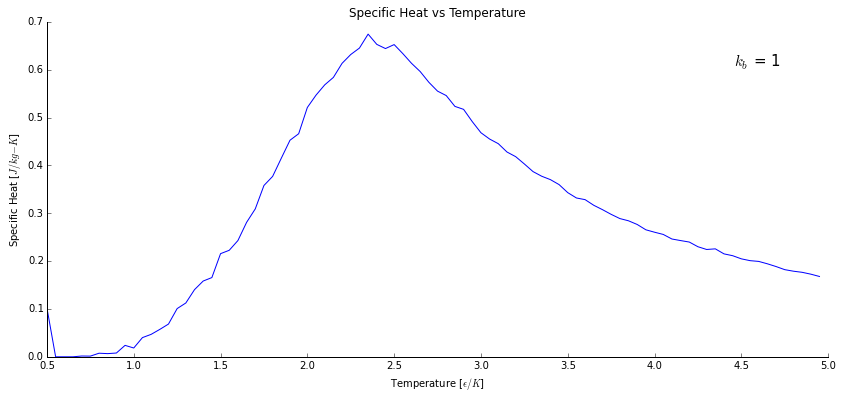

In [39]:
myplot(Temps,SpecificHeat)
plt.xlabel("Temperature [$\epsilon /K$]");
plt.ylabel("Specific Heat [$J/kg-K$]");
plt.title("Specific Heat vs Temperature");
plt.text(np.max(Temps)*.9,np.max(SpecificHeat)*.9,"$k_b$ = " + str(k),fontsize=15);

What temperature does the transition occur at and what is happening here?

Near T = 2.2 we see the specific heat begin to spike which indicates a phase transition. The specific heat rises sharply due to the large amount of energy necessary to flip the dipole system from arranged state to the randomly oriented state.

# 6. Magnetic Field

In [ ]:
t = 100 #Number of MC timesteps

In [48]:
def pointME(s,B):
    """Computes the magnetic energy of a single dipole due to the magnetic field."""
    return -s*B

In [49]:
def BenergyArray(lattice,B):
    """Loop over all entries in lattice, calculate the energy at each point due to B, then place that energy into the
    corresponding index of array of the same shape as the input array and return"""
    rows = lattice.shape[0]
    cols = lattice.shape[1]
    array = np.zeros((rows,cols),dtype=np.float)

    for i in np.arange(rows):
        for j in np.arange(cols):
            Spin = lattice[i,j]
            array[i,j] = pointME(Spin,B)
    return array

In [50]:
def EnergyArray(lattice,B):
    """When handed a lattice of spins, this function will separately compute the energy at each point in the 
    lattice due to dipole coupling and due to the applied magnetic field. These two energies are then summed 
    at each point and placed into the corresponding index of a lattice of the same shape as the input lattice."""
    
    BEnergy = BenergyArray(lattice,B)
    DEnergy = energyArray(lattice)
    
    NetEnergy = BEnergy + DEnergy
    
    return NetEnergy

In [51]:
def BFlip(row,col,lattice,T,B):
    """A function that when handed a lattice point will decide whether or not to flip the spin of that point.
       This is the same function as earlier, except now it factors in magnetic field energy."""
    
    PreFlipLattice = np.copy(lattice)
    PostFlipLattice = np.copy(lattice)
    
    Spin = PreFlipLattice[row,col]
    
    #Flipping the spin at [row,col]
    np.put(PostFlipLattice[row,:],[col],-Spin)
    
    Ef = EnergyArray(PostFlipLattice,B)[row,col] - EnergyArray(PreFlipLattice,B)[row,col]
    
    if Ef <= 0:
        return True
    elif np.random.random_sample() < boltz(Ef,T): #Return random floats in the half-open interval [0.0, 1.0).
        return True
    else:
        return False

In [52]:
def BLatticeAdvance(lattice,T,B):
    """Performs a single monte carlo timestep. Loops over every point in the lattice and Flips the spin
        of that point if BFlip returns True. Then returns the final lattice."""
    NewLattice = np.copy(lattice)
    for i in np.arange(NewLattice.shape[0]):
            for j in np.arange(NewLattice.shape[1]):
                Spin = NewLattice[i,j]
                if BFlip(i,j,NewLattice,T,B):
                    np.put(NewLattice[i,:],[j],-Spin)
    return NewLattice

In [53]:
def BSim(lattice,T,t,B):
    """Advances the input lattice for t number of monte carlo time units.
    
    Returns:
    Magnetization - <M> over all steps of the simulation.
    Final Lattice - "Equilibrium Configuration" at the end of the simulation """
    
    CurrentLattice = np.copy(lattice)
    
    Magnetization = np.array([AverageM(CurrentLattice)])
    
    for i in np.arange(t):
        CurrentLattice = BLatticeAdvance(CurrentLattice,T,B)
        Magnetization = np.append(Magnetization, AverageM(CurrentLattice))
        
    FinalLattice = CurrentLattice
    
    return FinalLattice, np.mean(Magnetization)

In [54]:
def BIncrease(lattice,Fields,t):
    """Advances the input lattice (t number of MC time units) for each value of Magnetic Field in Fields 
       without resetting the lattice at each new field.
       
    Returns:
    Magnetizations_ - <M> for each field strength
    """
    CurrentLattice = np.copy(lattice)
    
    #Initializing arrays, will append data from each new field strength to these arrays.
    Magnetizations = np.array([AverageM(CurrentLattice)])
    
    for i in np.arange(len(Fields)):
        CurrentLattice, Magnetization = BSim(CurrentLattice,T,t,Fields[i])
        
        Magnetizations = np.append(Magnetizations,Magnetization)
        
    #Slicing off the first entries, they are from first lattice (randomly generated) and don't match to any applied field.   
    Magnetizations = Magnetizations[1:]
    
    return Magnetizations

##### T = 2

In [55]:
T = 2
FinalMagnetizations = BIncrease(TestLattice,Fields,t)

In [56]:
def myplot2(x,y):
    #Removing Top/Right Spine/Ticks
    f, ax = plt.subplots(1, 1,figsize=(14,6))
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    
    ax.spines['left'].set_position('center')
    ax.spines['bottom'].set_position('center')
    
    plt.plot(x,y);
steps = np.arange(t)

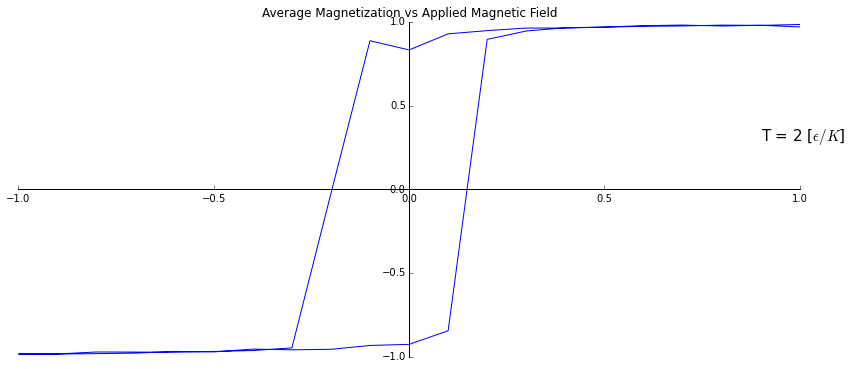

In [57]:
myplot2(Fields,FinalMagnetizations)
#plt.xlabel("Applied Magnetic Field [T]");
#plt.ylabel("Average Magnetization ");
plt.title("Average Magnetization vs Applied Magnetic Field");
plt.text(np.max(Fields)*.9,np.max(Magnetizations_)*1.001,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

##### T = 2.5

In [58]:
T = 2.5
FinalMagnetizations = BIncrease(TestLattice,Fields,t)

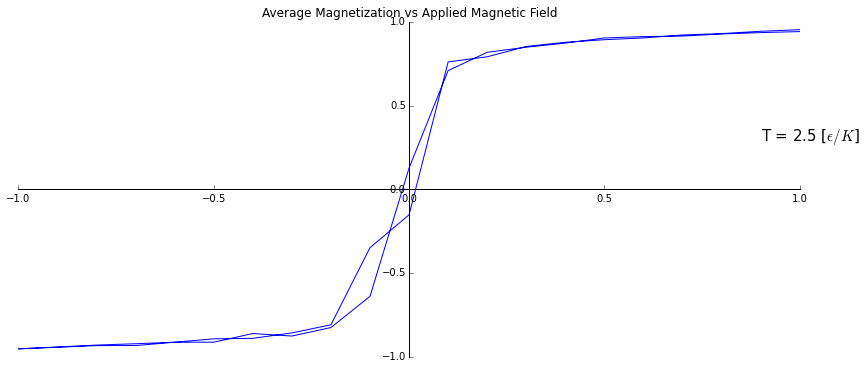

In [59]:
myplot2(Fields,FinalMagnetizations)
#plt.xlabel("Applied Magnetic Field [T]");
#plt.ylabel("Average Magnetization ");
plt.title("Average Magnetization vs Applied Magnetic Field");
plt.text(np.max(Fields)*.9,np.max(Magnetizations_)*1.001,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);

##### T = 3

In [60]:
T = 3
FinalMagnetizations = BIncrease(TestLattice,Fields,t)

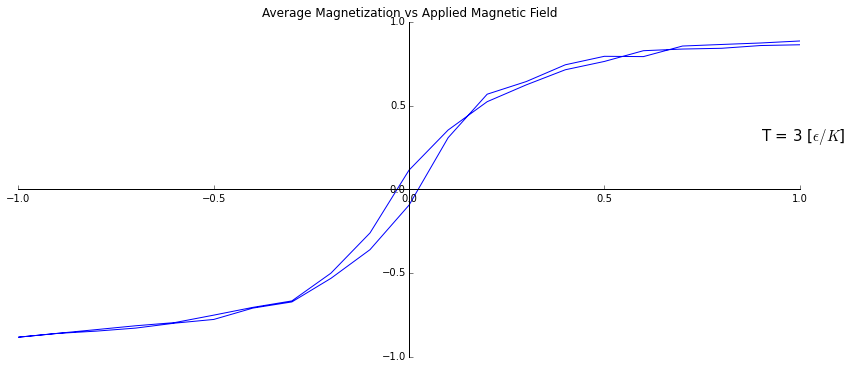

In [61]:
myplot2(Fields,FinalMagnetizations)
#plt.xlabel("Applied Magnetic Field [T]");
#plt.ylabel("Average Magnetization ");
plt.title("Average Magnetization vs Applied Magnetic Field");
plt.text(np.max(Fields)*.9,np.max(Magnetizations_)*1.001,"T = " + str(T) + " [$\epsilon /K$]",fontsize=15);